# PyTorch에서 이미지를 사용한 로지스틱 회귀

## 이 노트북에서 다룰 내용
1. PyTorch에서 이미지 작업(MNIST 데이터 세트 사용)
2. 데이터 세트를 훈련, 검증 및 테스트 세트로 분할
3. `nn.Module` 클래스를 확장하여 사용자 정의 로직으로 PyTorch 모델 생성
4. Softmax를 사용하여 모델 출력을 확률로 해석하고 예측된 레이블 선택
5. 분류 문제에 대한 유용한 평가 지표(정확도) 및 손실 함수(교차 엔트로피) 선택
6. 검증 세트를 사용하여 모델을 평가하는 훈련 루프 설정
7. 무작위로 선택한 예제에서 수동으로 모델 테스트
8. 처음부터 다시 학습하지 않도록 모델 체크포인트 저장 및 로드

## 이미지 작업

이 노트북에서는 PyTorch 및 선형 회귀에 대한 기존 지식을 사용하여 매우 다른 종류의 문제인 *이미지 분류*를 해결할 것이다.

우리는 유명한 [*MNIST 손으로 쓴 숫자 데이터베이스*](http://yann.lecun.com/exdb/mnist/)를 훈련 데이터 세트로 사용할 것이다.

손으로 쓴 숫자(0~9)의 28픽셀 x 28픽셀 그레이스케일 이미지와 각 이미지가 나타내는 숫자를 나타내는 레이블로 구성된다.

다음은 데이터세트의 샘플 이미지다.

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

먼저 `torch`와 `torchvision`을 설치하고 임포트 한다.

`torchvision`에는 이미지 데이터 작업을 위한 몇 가지 유틸리티가 포함되어 있다.

또한 MNIST와 같은 인기 있는 데이터 세트를 자동으로 다운로드하고 가져올 수 있는 도우미 클래스를 제공합니다.

In [1]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

In [2]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/home/dilab/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


이 명령문이 처음 실행되면 노트북 옆의 `data/` 디렉토리에 데이터를 다운로드하고 PyTorch `Dataset`을 생성한다.

데이터 세트의 크기를 확인해보자.

In [4]:
len(dataset)

60000

데이터 세트에는 모델을 훈련하는 데 사용할 60,000개의 이미지가 있다.

또한 모델을 평가하는데 사용되는 10,000개 이미지의 추가 테스트 세트가 있다.

`train=False`를 생성자에 전달하여 `MNIST` 클래스를 사용하여 테스트 데이터 세트를 만들 수 있다.

In [5]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

훈련 데이터 세트의 샘플 요소를 살펴보자.

In [6]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F7B80BA4AC0>, 5)

28x28px(픽셀)의 이미지와 레이블로 구성된 쌍이다.

이미지는 파이썬 이미징 라이브러리 [Pillow](https://pillow.readthedocs.io/en/stable/)의 일부인 `PIL.Image.Image` 클래스의 객체다.

Python의 데이터 과학을 위한 사실상의 플로팅 및 그래프 라이브러리인 [`matplotlib`](https://matplotlib.org/)를 사용하여 Jupyter 내에서 이미지를 볼 수 있다.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

`%matplotlib inline` 문은 Jupyter에 노트북 내에서 그래프를 플롯하기를 원한다는 것을 나타낸다.

이 줄이 없으면 Jupyter는 이미지를 팝업으로 표시한다.

`%`로 시작하는 명령문을 매직 명령이라고 하며 Jupyter 자체의 동작을 구성하는 데 사용다. 여기에서 매직 명령의 전체 리스트를 찾을 수 있다.

https://ipython.readthedocs.io/en/stable/interactive/magics.html .

데이터 세트에서 몇 가지 이미지를 살펴보겠다.

Label: 5


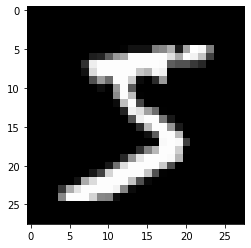

In [8]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


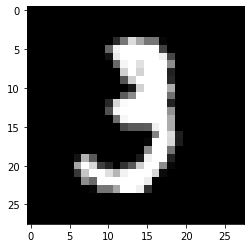

In [9]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

이러한 이미지는 크기가 상대적으로 작으며 숫자를 인식하는 것은 사람의 눈으로도 때때로 어려울 수 있다.

이러한 이미지를 보는 것이 유용하지만 여기에는 한 가지 문제가 있다. PyTorch는 이미지를 처리하는 라이브러리가 따로 존재하지 않는다.

그렇기에 우리는 이미지를 텐서로 변환하고, 데이터 세트를 생성하는 동안 특정한 변환 작업을 지정해 이미지 데이터를 처리할 수 있다.

In [10]:
import torchvision.transforms as transforms

PyTorch 데이터 세트를 사용하면 이미지가 로드될 때 이미지에 적용되는 하나 이상의 변환 기능을 지정할 수 있다.

`torchvision.transforms` 모듈에는 이러한 사전정의 기능이 많이 포함되어 있다.

`ToTensor` 변환을 사용하여 이미지를 PyTorch 텐서로 변환한다.

In [11]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [12]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


이제 이미지가 1x28x28 텐서로 변환된다. 첫 번째 차원은 색상 채널을 추적한다.

두 번째 및 세 번째 차원은 각각 이미지의 높이와 너비에 따른 픽셀을 나타낸다.

MNIST 데이터 세트의 이미지는 회색조이므로 채널이 하나만 있다.

다른 데이터 세트에는 색상이 있는 이미지가 있으며 이 경우 빨간색, 녹색 및 파란색(RGB)의 세 가지 채널이 있다.

텐서 내부의 몇 가지 샘플 값을 살펴보자.

In [13]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


값의 범위는 0에서 1까지이며, `0`은 검정, `1`은 흰색, 서로 다른 회색 음영 사이의 값이다.

`plt.imshow`를 사용하여 텐서를 이미지로 그릴 수도 있다.

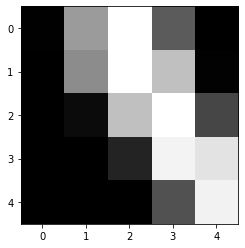

In [14]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

채널 차원 없이 28x28 행렬만 `plt.imshow`에 전달해야 한다.

또한 그레이스케일(흑백) 이미지를 보고 싶다는 것을 나타내기 위해 컬러 맵(`cmap=gray`)으로 세팅해야 한다.

## 교육(Training) 및 검증(Validation) 데이터 세트

기계 학습 모델을 구축하는 동안 데이터 세트를 세 부분으로 나누는 것이 일반적이다.

1. **훈련 세트(Training set)** - 모델 훈련에 사용 즉, 손실을 계산하고 경사하강법을 사용하여 모델의 가중치를 조정

2. **검증 세트(Validation set)** - 훈련 중 모델을 평가하고, 하이퍼파라미터(학습률 등)를 조정하고, 모델의 최상의 버전을 선택하는 데 사용

3. **테스트 세트(Test set)** - 다양한 모델 또는 접근 방식을 비교하고 모델의 최종 정확도를 보고하는 데 사용

MNIST 데이터셋에는 60,000개의 훈련 이미지와 10,000개의 테스트 이미지가 있다. 테스트 세트는 표준화되어 여러 연구자가 동일한 이미지 컬렉션에 대해 모델 결과를 보고할 수 있다.


사전 정의된 검증 세트가 없기 때문에 60,000개의 이미지를 훈련 및 검증 데이터 세트로 수동으로 분할해야 한다. 유효성 검사를 위해 무작위로 선택한 10,000개의 이미지를 따로 보관해 보자. PyTorch의 `random_spilt` 메서드를 사용하여 이 작업을 수행할 수 있다.

In [15]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

검증 세트를 생성하기 위해 무작위 샘플을 선택하는 것은 필수다. 훈련 데이터는 종종 대상 레이블, 즉 0, 1, 2 등의 이미지로 정렬된다. 이미지의 마지막 20%를 사용하여 유효성 검사 세트를 생성하면 8과 9로만 구성된다. 반면, 훈련 세트에는 8 또는 9가 포함되지 않습니다.

이러한 훈련 검증은 유용한 모델을 훈련하는 것을 불가능하게 만든다. 이제 데이터를 일괄적으로 로드하는 데 도움이 되는 데이터 로더를 만들 수 있다. 배치 크기 128을 사용한다.

In [16]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

각 epoch에서 생성된 배치가 서로 다른지 확인하기 위해 훈련 데이터 로더에 `shuffle=True`를 설정했다.

이 무작위화는 훈련 과정을 일반화하고 속도를 높이는 데 도움이 된다.

반면 검증 데이터 로더는 모델 평가에만 사용되기 때문에 이미지를 섞을 필요가 없다.

## 모델

이제 데이터 로더를 준비했으므로 모델을 정의할 수 있다.

* **로지스틱 회귀** 모델은 선형 회귀 모델과 거의 동일하다. 여기에는 가중치와 편향 행렬이 포함되어 있으며 간단한 행렬 연산(`pred = x @ w.t() + b`)을 사용하여 출력을 얻는다.

* 선형 회귀에서 했던 것처럼 행렬을 수동으로 생성하고 초기화하는 대신 `nn.Linear`를 사용하여 모델을 생성할 수 있다.

* `nn.Linear`는 각 학습 예제가 벡터가 될 것으로 예상하므로 각 `1x28x28` 이미지 텐서는 모델에 전달되기 전에 크기 784 `(28*28)`의 벡터로 _평탄화(펼쳐)_된다.

* 각 이미지의 출력은 크기가 10인 벡터이며 각 요소는 특정 대상 레이블(즉, 0에서 9)의 확률을 나타낸다. 이미지에 대해 예측된 레이블은 단순히 확률이 가장 높은 레이블이다.

In [17]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

물론 이 모델은 매개변수의 수 면에서 이전 모델보다 훨씬 크다.

가중치와 편향에 대해 살펴보자.

In [18]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0266, -0.0026, -0.0019,  ...,  0.0302,  0.0276, -0.0094],
        [ 0.0062, -0.0029, -0.0237,  ...,  0.0011,  0.0062, -0.0046],
        [ 0.0033,  0.0239, -0.0286,  ..., -0.0235, -0.0094, -0.0135],
        ...,
        [-0.0302, -0.0083,  0.0355,  ..., -0.0147,  0.0258, -0.0147],
        [-0.0194,  0.0175, -0.0292,  ...,  0.0109, -0.0126,  0.0329],
        [ 0.0252, -0.0354,  0.0275,  ..., -0.0344, -0.0097,  0.0229]],
       requires_grad=True)

In [19]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0311, -0.0306, -0.0240,  0.0032,  0.0047,  0.0091,  0.0204,  0.0016,
        -0.0283, -0.0335], requires_grad=True)

여기에는 총 7850개의 매개변수가 있지만 개념적으로는 지금까지 변경된 것이 없다.

모델을 사용하여 일부 출력을 생성해 보겠다.

데이터 세트에서 100개의 이미지 중 첫 번째 배치를 가져와서 모델에 전달한다.

In [20]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([1, 2, 5, 3, 8, 4, 5, 3, 9, 1, 2, 2, 8, 7, 2, 6, 8, 4, 1, 7, 9, 2, 8, 9,
        7, 4, 5, 9, 0, 1, 6, 3, 7, 3, 8, 7, 3, 2, 6, 4, 0, 5, 4, 1, 9, 5, 0, 6,
        5, 6, 8, 2, 6, 8, 5, 1, 8, 5, 0, 4, 0, 5, 7, 4, 9, 4, 1, 4, 9, 9, 4, 5,
        1, 1, 7, 1, 3, 2, 0, 5, 8, 5, 5, 0, 9, 5, 9, 1, 5, 4, 1, 1, 1, 3, 8, 0,
        9, 3, 3, 4, 2, 2, 4, 5, 1, 7, 8, 8, 2, 8, 4, 8, 8, 3, 8, 3, 0, 2, 6, 6,
        9, 9, 7, 4, 9, 7, 8, 8])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

In [21]:
images.shape

torch.Size([128, 1, 28, 28])

In [22]:
images.reshape(128, 784).shape

torch.Size([128, 784])

위의 코드는 입력 데이터의 모양이 맞지 않기 때문에 오류가 발생한다.

우리의 이미지는 1x28x28 모양이지만 크기가 784인 벡터가 필요하다. 즉, 평면화해야한다.

텐서의 `.reshape`메서드를 사용하면 기본 데이터의 복사본을 실제로 생성하지 않고도 각 이미지를 평면 벡터로 효율적으로 `볼` 수 있다.

이 추가 기능을 모델에 포함하려면 PyTorch에서 `nn.Module` 클래스를 확장하여 사용자 정의 모델을 정의해야 한다.


Python의 클래스는 객체 생성을 위한 `"청사진"`을 제공한다. Python에서 새 클래스를 정의하는 예를 살펴보겠다.

In [23]:
class Person:
    # Class constructor
    def __init__(self, name, age):
        # Object properties
        self.name = name
        self.age = age
    
    # Method
    def say_hello(self):
        print("Hello my name is " + self.name + "!")

다음은 `Person` 클래스의 객체를 생성하거나 _인스턴스화_하는 방법이다.

In [24]:
bob = Person("Bob", 32)

`bob` 객체는 `Person` 클래스의 인스턴스이다.

객체의 속성(속성이라고도 함)에 액세스하거나 `.` 표기법을 사용하여 해당 메서드를 호출할 수 있다.

In [25]:
bob.name, bob.age

('Bob', 32)

In [26]:
bob.say_hello()

Hello my name is Bob!


https://www.w3schools.com/python/python_classes.asp에서 Python 클래스에 대해 자세히 알아볼 수 있다.

또한 클래스는 기존 클래스의 기능을 기반으로 하거나 _확장_할 수 있다. PyTorch에서 `nn.Module` 클래스를 확장하여 사용자 정의 모델을 정의해 보겠다.

In [27]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

`__init__` 생성자 메서드 내에서 `nn.Linear`를 사용하여 가중치와 편향을 인스턴스화합니다.

그리고 입력 일괄 처리를 모델에 전달할 때 호출되는 `forward`메서드 내부에서 입력 텐서를 평평하게 만들고 이를 `self.linear`에 전달한다.

`xb.reshape(-1, 28*28)`은 2차원의 `xb` 텐서의 *보기*를 원한다는 것을 PyTorch에 나타낸다.

2차원의 길이는 28\*28(즉, 784)이다.

`.reshape`에 대한 한 인수를 `-1`(이 경우 첫 번째 차원)로 설정하면 PyTorch가 원래 텐서의 모양을 기반으로 자동으로 알아낼 수 있다.

모델에는 더 이상 `.weight` 및 `.bias` 속성이 없지만(이제 `.linear` 속성 안에 있으므로) 가중치와 편향을 포함하는 목록을 반환하는 `.parameters` 메서드가 있다.

In [28]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [29]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0229, -0.0177,  0.0315,  ...,  0.0339,  0.0163, -0.0160],
         [-0.0059,  0.0097,  0.0205,  ..., -0.0029,  0.0007, -0.0280],
         [ 0.0053,  0.0273,  0.0319,  ...,  0.0100, -0.0268,  0.0163],
         ...,
         [ 0.0261, -0.0101, -0.0135,  ..., -0.0090,  0.0053,  0.0092],
         [-0.0304, -0.0119, -0.0262,  ...,  0.0343,  0.0258, -0.0093],
         [ 0.0076, -0.0243,  0.0294,  ..., -0.0248, -0.0305,  0.0161]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0247, -0.0292, -0.0042,  0.0335,  0.0072, -0.0030,  0.0185,  0.0234,
          0.0070,  0.0052], requires_grad=True)]

우리는 이전과 같은 방식으로 새로운 커스텀 모델을 사용할 수 있다.

작동하는지 보자.

In [30]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.2213,  0.1604, -0.2281,  0.0992, -0.0449, -0.2389, -0.0427,  0.4363,
          0.1643, -0.3218],
        [-0.0171,  0.0877, -0.3320,  0.1971,  0.1721, -0.1101,  0.0245,  0.2728,
          0.0228, -0.1300]])


100개의 입력 이미지 각각에 대해 각 클래스에 대해 하나씩 10개의 출력을 얻는다.

앞서 논의한 바와 같이, 우리는 이러한 출력이 확률을 나타내기를 원한다.

각 출력 행의 요소는 0에서 1 사이에 있어야 하며 합이 1이 되어야한다.

출력 행을 확률로 변환하기 위해 다음 공식을 갖는 softmax 함수를 사용한다.

![소프트맥스](https://i.imgur.com/EAh9jLN.png)

먼저 출력 행의 각 요소 `yi`를 `e^yi`로 교체하여 모든 요소를 양수로 만든다.

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)

그런 다음 합이 1이 되도록 합으로 나눈다. 따라서 결과 벡터는 확률로 해석될 수 있다.

softmax 함수를 구현하는 것은 쉽지만(시도해야 합니다!), 다차원 텐서(이 경우 출력 행 목록)와 잘 작동하기 때문에 PyTorch 내에서 제공되는 구현을 사용한다.

In [31]:
import torch.nn.functional as F

softmax 함수는 `torch.nn.functional` 패키지에 포함되어 있으며 함수를 적용해야 하는 차원을 지정해야 한다.

In [32]:
outputs[:2]

tensor([[-0.2213,  0.1604, -0.2281,  0.0992, -0.0449, -0.2389, -0.0427,  0.4363,
          0.1643, -0.3218],
        [-0.0171,  0.0877, -0.3320,  0.1971,  0.1721, -0.1101,  0.0245,  0.2728,
          0.0228, -0.1300]], grad_fn=<SliceBackward>)

In [33]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0799, 0.1171, 0.0794, 0.1101, 0.0953, 0.0785, 0.0955, 0.1543, 0.1175,
         0.0723],
        [0.0951, 0.1056, 0.0694, 0.1179, 0.1150, 0.0867, 0.0992, 0.1271, 0.0990,
         0.0850]])
Sum:  1.000000238418579


마지막으로 각 출력 행에서 확률이 가장 높은 요소의 인덱스를 선택하기만 하면 각 이미지에 대한 예측 레이블을 결정할 수 있다.

각 행의 가장 큰 요소와 해당 인덱스를 반환하는 `torch.max`를 사용하여 이를 수행할 수 있다.

In [34]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([7, 7, 3, 7, 7, 7, 5, 7, 7, 7, 8, 7, 7, 7, 7, 7, 4, 4, 8, 7, 7, 4, 7, 8,
        0, 8, 7, 7, 7, 9, 7, 7, 4, 1, 9, 4, 9, 7, 3, 8, 7, 7, 7, 4, 8, 8, 1, 0,
        9, 7, 7, 8, 7, 7, 4, 8, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7,
        8, 7, 4, 7, 5, 0, 9, 4, 7, 0, 7, 7, 7, 7, 4, 7, 7, 1, 2, 8, 7, 7, 7, 5,
        0, 3, 7, 8, 7, 7, 1, 7, 1, 7, 0, 4, 3, 9, 3, 4, 7, 7, 7, 2, 8, 7, 4, 7,
        7, 9, 7, 7, 4, 7, 0, 7])
tensor([0.1543, 0.1271, 0.1253, 0.1368, 0.1524, 0.1287, 0.1266, 0.1298, 0.1316,
        0.1464, 0.1167, 0.1411, 0.1365, 0.1410, 0.1389, 0.1313, 0.1131, 0.1463,
        0.1129, 0.1345, 0.1347, 0.1221, 0.1192, 0.1125, 0.1293, 0.1127, 0.1325,
        0.1232, 0.1349, 0.1313, 0.1259, 0.1192, 0.1171, 0.1187, 0.1231, 0.1320,
        0.1179, 0.1149, 0.1306, 0.1182, 0.1421, 0.1378, 0.1189, 0.1579, 0.1141,
        0.1247, 0.1137, 0.1307, 0.1213, 0.1525, 0.1291, 0.1424, 0.1243, 0.1275,
        0.1282, 0.1364, 0.1387, 0.1335, 0.1457, 0.1195, 0.1426, 0.1276, 0.1433,
       

위에 인쇄된 숫자는 훈련 이미지의 첫 번째 배치에 대한 예측된 레이블이다.

실제 라벨과 비교해 보겠다.

In [35]:
labels

tensor([8, 4, 3, 0, 8, 0, 0, 2, 9, 2, 3, 7, 7, 4, 0, 9, 9, 7, 1, 4, 2, 3, 4, 1,
        3, 1, 8, 6, 5, 1, 7, 5, 1, 8, 1, 9, 1, 4, 7, 6, 2, 8, 6, 8, 6, 9, 8, 6,
        1, 8, 2, 8, 2, 7, 4, 5, 5, 4, 3, 6, 8, 6, 3, 1, 0, 6, 6, 5, 8, 2, 7, 8,
        5, 6, 3, 1, 6, 6, 1, 3, 2, 6, 2, 8, 2, 0, 9, 4, 7, 6, 5, 8, 4, 9, 0, 6,
        8, 7, 0, 2, 4, 4, 1, 7, 6, 1, 4, 7, 5, 2, 2, 7, 5, 4, 2, 3, 6, 5, 9, 4,
        0, 1, 4, 2, 1, 7, 6, 3])

대부분의 예측된 레이블은 실제 레이블과 다르다. 무작위로 초기화된 가중치와 편향으로 시작했기 때문이다.

모델을 훈련시켜야한다. 즉, 더 나은 예측을 위해 경사하강법을 사용하여 가중치를 조정해야한다.

## 평가 메트릭 및 손실 함수

선형 회귀와 마찬가지로 모델의 성능을 평가할 방법이 필요하다.

이를 수행하는 자연스러운 방법은 올바르게 예측된 레이블의 백분율(예측의 **정확도**)을 찾는 것이다.

In [36]:
outputs[:2]

tensor([[-0.2213,  0.1604, -0.2281,  0.0992, -0.0449, -0.2389, -0.0427,  0.4363,
          0.1643, -0.3218],
        [-0.0171,  0.0877, -0.3320,  0.1971,  0.1721, -0.1101,  0.0245,  0.2728,
          0.0228, -0.1300]], grad_fn=<SliceBackward>)

In [37]:
torch.sum(preds == labels)

tensor(13)

In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

`==` 연산자는 모양이 같은 두 텐서의 요소별 비교를 수행하고 같지 않은 요소에 대해 `True`를 포함하고 동일한 요소에 대해 `False`를 포함하는 동일한 모양의 텐서를 반환한다. 결과를 `torch.sum`에 전달하면 올바르게 예측된 레이블 수를 반환한다. 마지막으로 정확도를 얻기 위해 총 이미지 수로 나눈다.


결과가 동일한 상대 순서를 가지므로 출력에 softmax를 적용할 필요가 없다. 이는 `e^x`가 증가 함수이기 때문이다. 즉, `y1 > y2`이면 `e^y1 > e^y2`이다. softmax를 얻기 위해 값을 평균화한 후에도 마찬가지다.

데이터의 첫 번째 배치에서 현재 모델의 정확도를 계산해 보겠다.

In [39]:
accuracy(outputs, labels)

tensor(0.1016)

In [40]:
probs

tensor([[0.0799, 0.1171, 0.0794,  ..., 0.1543, 0.1175, 0.0723],
        [0.0951, 0.1056, 0.0694,  ..., 0.1271, 0.0990, 0.0850],
        [0.0968, 0.1162, 0.0988,  ..., 0.1173, 0.1054, 0.0942],
        ...,
        [0.0973, 0.0981, 0.0985,  ..., 0.1513, 0.0930, 0.0922],
        [0.1256, 0.1017, 0.0779,  ..., 0.0982, 0.1165, 0.0775],
        [0.1119, 0.1058, 0.0907,  ..., 0.1297, 0.1204, 0.0736]],
       grad_fn=<SoftmaxBackward>)

정확도는 우리가 모델을 평가하는 훌륭한 방법이다. 그러나 다음과 같은 이유로 경사하강법을 사용하여 모델을 최적화하기 위한 손실 함수로 사용할 수 없다.

1. 미분이 되지 않음 `torch.max`와 `==`는 모두 비연속적이고 미분할 수 없는 연산이므로 가중치와 편향으로 기울기를 계산하는 데 정확도를 사용할 수 없음

2. 모델에 의해 예측된 실제 확률을 고려하지 않으므로 점진적 개선에 대한 충분한 피드백을 제공할 수 없음.


이러한 이유로 종종 정확도는 분류 평가 지표로 활용되긴하지만, 손실함수로 사용되지 않는다.  분류 문제에 일반적으로 사용되는 손실 함수는 **교차 엔트로피**이며 아래에 공식이 있다.

![크로스 엔트로피](https://i.imgur.com/VDRDl1D.png)

복잡해 보이지만 실제로는 매우 간단하다.

* 각 출력 행에 대해 올바른 레이블에 대한 예측 확률을 선택한다.

예를 들어 이미지에 대한 예측 확률이 `[0.1, 0.3, 0.2, ...]`이고 올바른 레이블이 `1`이면 해당 요소 `0.3`을 선택하고 나머지는 무시한다.

* 그런 다음 선택한 확률의 [logarithm](https://en.wikipedia.org/wiki/Logarithm)을 취한다.

확률이 높으면, 즉 1에 가까우면 로그는 0에 가까운 매우 작은 음수 값이다. 그리고 확률이 낮으면(0에 가까움) 로그는 매우 큰 음수 값이다. 또한 결과에 -1을 곱한다. 이는 결과가 좋지 않은 예측에 대한 손실의 큰 양수 값이다.


![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* 마지막으로 모든 출력 행에 대한 교차 엔트로피의 평균을 취하여 데이터 배치에 대한 전체 손실을 얻는다.

정확도와 달리 교차 엔트로피는 연속적이고 미분 가능한 함수다. 또한 모델의 점진적 개선에 대한 유용한 피드백을 제공한다(정확한 레이블에 대한 약간 더 높은 확률은 더 낮은 손실로 이어짐). 이 두 가지 요소는 교차 엔트로피를 손실 함수에 더 나은 선택으로 만든다.


예상할 수 있듯이 PyTorch는 `torch.nn.functional` 패키지의 일부로 효율적이고 텐서 친화적인 교차 엔트로피 구현을 제공한다. 또한 내부적으로 softmax를 수행하므로 확률로 변환하지 않고 모델의 출력을 직접 전달할 수 있다.

In [41]:
outputs

tensor([[-0.2213,  0.1604, -0.2281,  ...,  0.4363,  0.1643, -0.3218],
        [-0.0171,  0.0877, -0.3320,  ...,  0.2728,  0.0228, -0.1300],
        [-0.0406,  0.1420, -0.0203,  ...,  0.1516,  0.0442, -0.0680],
        ...,
        [-0.0916, -0.0834, -0.0794,  ...,  0.3498, -0.1367, -0.1454],
        [ 0.2405,  0.0297, -0.2364,  ..., -0.0056,  0.1652, -0.2425],
        [ 0.0627,  0.0069, -0.1473,  ...,  0.2104,  0.1357, -0.3558]],
       grad_fn=<AddmmBackward>)

In [42]:
loss_fn = F.cross_entropy

In [43]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3075, grad_fn=<NllLossBackward>)


우리는 교차 엔트로피가 모든 훈련 샘플에 대해 평균화된 올바른 레이블의 예측 확률의 음의 로그라는 것을 알고 있다. 따라서 결과 숫자를 해석하는 한 가지 방법은 다음과 같습니다. `2.23`은 `e^-2.23`을 보면 평균적으로 올바른 레이블의 예측 확률이 `0.1` 정도다.

*손실이 낮을수록 좋은 모델*

## 모델 훈련

데이터 로더, 모델, 손실 함수 및 옵티마이저를 정의했으므로 이제 모델을 훈련할 준비가 되었다.

훈련 과정은 각 시대의 모델을 평가하기 위해 "검증 단계"가 추가된 선형 회귀와 동일하다. 아래에 의사코드를 나타냈음:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

훈련 루프의 일부는 우리가 해결하고 있는 특정 문제(예: 손실 함수, 메트릭 등)에 특정한 반면 다른 부분은 일반적이며 모든 딥 러닝 문제에 적용할 수 있다. 모델을 훈련하는 데 사용할 `fit`이라는 함수에 문제와 무관한 부분을 포함할 것이다. 

문제별 부분은 `nn.Module` 클래스에 새 메서드를 추가하여 구현된다.

In [44]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

`fit`함수는 각 에포크의 유효성 검사 손실과 메트릭을 기록한다. 디버깅 및 시각화에 유용한 교육 기록을 반환한다.

배치 크기, 학습률 등과 같은 구성(초매개변수라고 함)은 기계 학습 모델을 학습하는 동안 미리 선택해야 한다.
적절한 초매개변수를 선택하는 것은 합리적인 시간 내에 합리적으로 정확한 모델을 훈련하는 데 중요하다. 머신 러닝의 연구 및 실험이 활발한 영역이다. 자유롭게 다양한 학습률을 시도하고 이것이 교육 과정에 어떤 영향을 미치는지 확인해보자.

`fit`의 유효성 검사 단계에서 사용되는 `evaluate`함수를 정의해 보겠다.

In [45]:
l1 = [1, 2, 3, 4, 5]

In [46]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [47]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

마지막으로 `fit` 및 `evaluate`에서 사용하는 추가 메소드 `training_step`, `validation_step`, `validation_epoch_end`, `epoch_end`를 포함하도록 `MnistModel` 클래스를 재정의해 보겠다.

In [48]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

모델을 훈련시키기 전에 무작위로 초기화된 가중치 및 편향의 초기 세트를 사용하여 검증 세트에서 모델이 어떻게 수행되는지 보자.

In [49]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3294854164123535, 'val_acc': 0.06744462251663208}

초기 정확도는 약 10%로 무작위로 초기화된 모델에서 기대할 수 있다(무작위로 추측하여 올바른 레이블을 얻을 확률이 10분의 1이기 때문에).

이제 모델을 훈련할 준비가 되었다. 5개의 Epoch 동안 훈련하고 결과를 살펴보겠다.

In [50]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9630, val_acc: 0.6008
Epoch [1], val_loss: 1.6926, val_acc: 0.7300
Epoch [2], val_loss: 1.4901, val_acc: 0.7661
Epoch [3], val_loss: 1.3368, val_acc: 0.7868
Epoch [4], val_loss: 1.2187, val_acc: 0.8000


좋은 결과입니다! 단 5개의 Epoch 훈련으로 우리 모델은 검증 세트에서 80% 이상의 정확도에 도달했다.

몇 에포크를 더 훈련하여 개선할 수 있는지 보자.

아래의 각 셀에서 학습률과 Epoch 수를 변경해 보세요.

In [52]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9392, val_acc: 0.8278
Epoch [1], val_loss: 0.8962, val_acc: 0.8314
Epoch [2], val_loss: 0.8594, val_acc: 0.8348
Epoch [3], val_loss: 0.8276, val_acc: 0.8384
Epoch [4], val_loss: 0.7997, val_acc: 0.8403


In [53]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7751, val_acc: 0.8425
Epoch [1], val_loss: 0.7532, val_acc: 0.8452
Epoch [2], val_loss: 0.7336, val_acc: 0.8469
Epoch [3], val_loss: 0.7159, val_acc: 0.8486
Epoch [4], val_loss: 0.6999, val_acc: 0.8504


In [54]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6853, val_acc: 0.8527
Epoch [1], val_loss: 0.6719, val_acc: 0.8542
Epoch [2], val_loss: 0.6596, val_acc: 0.8554
Epoch [3], val_loss: 0.6483, val_acc: 0.8558
Epoch [4], val_loss: 0.6377, val_acc: 0.8568


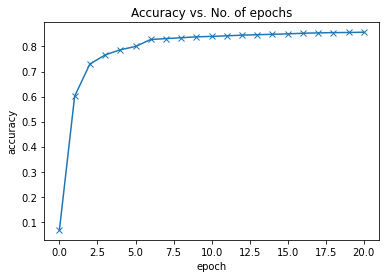

In [55]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

위의 그림을 보면 모델이 아주 오랜 시간 동안 훈련한 후에도 정확도 임계값 90%를 넘지 않을 것이라는 점을 아주 분명하게 알 수 있다. 이에 대한 한 가지 가능한 이유는 학습률이 너무 높을 수 있기 때문이다. 모델의 매개변수는 가장 낮은 손실을 위한 최적의 매개변수 세트를 중심으로 `"바운스"`할 수 있다. 학습률을 줄이고 몇 에포크를 더 훈련하여 도움이 되는지 확인할 수 있다.

**모델이 충분히 강력하지 않은** 이유가 더 많다. 초기 가설을 기억한다면 출력(이 경우 클래스 확률)은 입력(픽셀 강도)과 가중치 행렬 곱을 수행하고 편향을 더한 결과인 **선형 함수**이다. 이미지의 픽셀 강도와 이미지가 나타내는 숫자 사이에 선형 관계가 실제로 존재하지 않을 수 있으므로 이것은 상당히 약한 가정이다.

MNIST(85% 정확도 제공)와 같은 간단한 데이터 세트에서는 합리적으로 잘 작동하지만 일상적인 물체, 동물 등을 인식하는 것과 같은 복잡한 작업을 위해 이미지 픽셀과 레이블 간의 비선형 관계를 캡처할 수 있는 보다 정교한 모델이 필요하다.

## 개별 이미지로 테스트

지금까지 모델의 전체 정확도를 추적했지만 일부 샘플 이미지에서 모델의 결과를 확인하는 것도 좋은 생각일 것이다.

미리 정의된 10000개 이미지의 테스트 데이터 세트에서 일부 이미지로 모델을 테스트해 보자.

`ToTensor`변환을 사용하여 테스트 데이터 세트를 다시 만드는 것으로 시작하자.

In [56]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


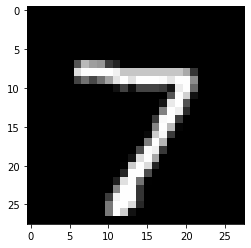

In [57]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

단일 이미지 텐서에 대해 예측된 레이블을 반환하는 도우미 함수 `predict_image`를 정의해 보겠다.

In [58]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze`는 1x28x28 텐서의 시작 부분에 다른 차원을 추가하여 1x1x28x28 텐서를 만들고 모델이 단일 이미지를 포함하는 배치로 보자.

몇 개의 이미지로 시도해 보자.

Label: 7 , Predicted: 7


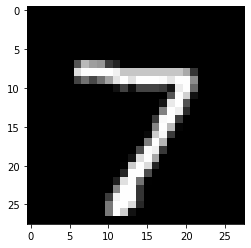

In [59]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


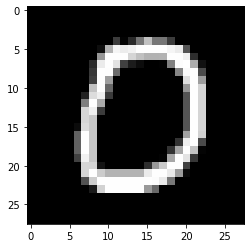

In [60]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


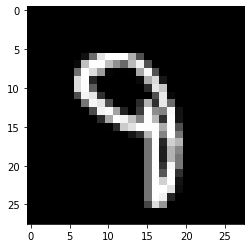

In [61]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


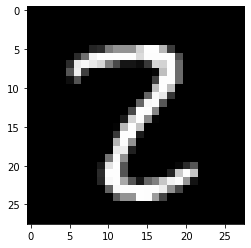

In [62]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

모델 성능이 저조한 위치를 식별하면 더 많은 교육 데이터를 수집하고 모델의 복잡성을 늘리거나 줄이며 하이퍼파라미터를 변경하여 모델을 개선하는 데 도움이 될 수 있다.

마지막 단계로 테스트 세트에서 모델의 전체 손실과 정확도도 살펴보자.

In [63]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.606325089931488, 'val_acc': 0.865039050579071}

이것이 검증 세트의 정확도/손실과 유사할 것으로 예상된다.

그렇지 않은 경우 테스트 세트(종종 실제 데이터에서 가져옴)와 유사한 데이터 및 분포를 가진 더 나은 검증 세트가 필요할 수 있다.

## 모델 저장 및 불러오기

우리는 오랜 시간 동안 모델을 훈련했고 상당한 정확도를 달성했기 때문에 나중에 모델을 재사용하고 처음부터 다시 훈련하지 않도록 가중치와 편향 행렬을 디스크에 저장하는 것이 좋다. 

모델을 저장하는 방법은 아래와 같다.

In [64]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

`.state_dict` 메소드는 모델의 올바른 속성에 매핑된 모든 가중치와 편향 행렬을 포함하는 `OrderedDict`를 반환한다.

In [65]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 1.5897e-03,  1.4094e-02,  6.9776e-03,  ...,  1.0001e-02,
                        4.2146e-04,  5.3545e-03],
                      [-1.2061e-02, -1.0422e-02, -2.0551e-02,  ..., -2.6979e-03,
                       -3.5059e-02, -2.0220e-02],
                      [-4.5509e-04,  4.6315e-03,  2.2319e-02,  ...,  1.2776e-02,
                        3.2915e-02, -7.8641e-03],
                      ...,
                      [ 5.4894e-03, -3.2955e-02, -9.4656e-05,  ..., -2.0017e-02,
                        9.5782e-03, -1.5799e-02],
                      [-2.1682e-02,  2.8357e-02,  3.2435e-02,  ..., -3.4468e-02,
                       -1.9810e-02,  3.5382e-02],
                      [ 1.8925e-02,  2.3795e-02,  2.5661e-02,  ..., -9.8993e-03,
                       -2.1034e-03,  9.2217e-03]])),
             ('linear.bias',
              tensor([-0.0790,  0.0707, -0.0161, -0.0241,  0.0467,  0.0795, -0.0009,  0.0380,
                      -0.0811,

모델 가중치를 로드하기 위해 `MnistModel` 클래스의 새 객체를 인스턴스화하고 `.load_state_dict` 메소드를 사용할 수 있다.

In [66]:
model2 = MnistModel()

In [67]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0036,  0.0042, -0.0357,  ..., -0.0117,  0.0206, -0.0184],
                      [ 0.0281, -0.0338, -0.0348,  ...,  0.0302, -0.0154, -0.0303],
                      [ 0.0166,  0.0173,  0.0341,  ...,  0.0017,  0.0085, -0.0300],
                      ...,
                      [-0.0128, -0.0042, -0.0291,  ..., -0.0113,  0.0143,  0.0338],
                      [-0.0294,  0.0166,  0.0178,  ...,  0.0318,  0.0100, -0.0081],
                      [ 0.0144, -0.0150, -0.0219,  ...,  0.0018, -0.0261,  0.0130]])),
             ('linear.bias',
              tensor([ 0.0312, -0.0247, -0.0163, -0.0255, -0.0239,  0.0192,  0.0031,  0.0338,
                       0.0332, -0.0274]))])

In [68]:
evaluate(model2, test_loader)

{'val_loss': 2.3144640922546387, 'val_acc': 0.12509766221046448}

In [69]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 1.5897e-03,  1.4094e-02,  6.9776e-03,  ...,  1.0001e-02,
                        4.2146e-04,  5.3545e-03],
                      [-1.2061e-02, -1.0422e-02, -2.0551e-02,  ..., -2.6979e-03,
                       -3.5059e-02, -2.0220e-02],
                      [-4.5509e-04,  4.6315e-03,  2.2319e-02,  ...,  1.2776e-02,
                        3.2915e-02, -7.8641e-03],
                      ...,
                      [ 5.4894e-03, -3.2955e-02, -9.4656e-05,  ..., -2.0017e-02,
                        9.5782e-03, -1.5799e-02],
                      [-2.1682e-02,  2.8357e-02,  3.2435e-02,  ..., -3.4468e-02,
                       -1.9810e-02,  3.5382e-02],
                      [ 1.8925e-02,  2.3795e-02,  2.5661e-02,  ..., -9.8993e-03,
                       -2.1034e-03,  9.2217e-03]])),
             ('linear.bias',
              tensor([-0.0790,  0.0707, -0.0161, -0.0241,  0.0467,  0.0795, -0.0009,  0.0380,
                      -0.0811,

In [70]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.606325089931488, 'val_acc': 0.865039050579071}